In [1]:
import sys
sys.path.insert(1, "../python/architecture")
sys.path.insert(2, "../python/functions")

In [2]:
import numpy as np
from inverse_problem_functions import y_noise
from enkf_functions import enkf_inverse_problem
from plotting_functions import plot_IP_loss_evolution, plot_IP_loss_evolution_many, plot_IP_true_false, plot_IP_particle_loss, plot_IP_particle_std, plot_IP_iteration_std, plot_IP_cosine_sims, plot_IP_final_cosine_sim, plot_IP_convergence
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

In [3]:
def enkf_linear_problem_analysis(setting_dict,
                                 analysis_dict
                                 ):

    """ Ensemble Kalman Filter algorithm applied to a linear inverse problem with analysis options.


    Parameters:

    setting_dict (dict): Dictionary containing
        A (np.ndarray): Matrix A for the model Ax + noise = y.
        model_func (function): Function to apply to x.
        x (np.array): True parameters.
        y (np.array): True target variable.
        particles (int): Number of particles in the ensemble.
        epochs (int): Number of epochs.
        stepsize (float): Stepsize for update steps.
        noise (bool): Whether or not to add noise to the target variable.
        std (np.array): Standard deviation of the noise.
    analysis_dict (dict or None): Dictionary containing
        disjoint_batch (bool): Whether or not to use disjoint batches. If False then each batch is sampled with replacement.
        batch_particle_connection (dict): Dictionary containing
            connect (bool): Whether or not to connect particles and batches.
            shuffle (str or None): Whether or not and how to shuffle the connection. None = no shuffle. "permute" = change the allocation of the existing batches and particle sets. "particle" = shuffle the particle sets for fixed batches. "batch" = shuffle the batch for fixed particle sets. "full" = shuffle the particle sets and their corresponding batch.
        tikhonov (dict): Dictionary containing
            regularize (bool): Whether or not to use Tikhonov regularization.
            lambda (None or float): Lambda parameter in Tikhonov regularization.
            variance_inflation (dict): Dictionary containing
                inflation (bool): Whether or not to use variance inflation.
                alpha (float or None): Scaling parameter for identity matrix of the inflation.


    Returns:
    
    return_dict (dict): Dictionary containing
        final_params (np.ndarray): Final predicted parameter.
        loss_evolution (list): Evolution of the loss value over each epoch.
        loss_evolution_single_dict (dict): Evolutions of loss values of all particles.
        batch_particle_dict (dict or None): Dictionary with the final batch-particle-connection.
        param_init_dict (dict): Dictionary with the initial parameter estimates for each particle.
        param_dict (dict): Dictionary with the final parameter estimates for each particle.
        A (np.ndarray): Matrix A for the model Ax = y + noise.
        y (np.array): True target variable.
        tik_regularize (bool): Whether or not regularization was added to the model.
        tik_lambda (int or None): Lambda parameter in Tikhonov regularization.
        var_inflation (bool): Whether or not variance inflation was used.
        x_opt_subspace (float or None): Optimal parameter if subspace property holds.
        x_opt_fullSpace (float or None): Optimal parameter if subspace property does not hold.
        

    """

    A = setting_dict["A"]
    model_func = setting_dict["model_func"]
    x = setting_dict["x"]
    y = setting_dict["y"]
    particles = setting_dict["particles"]
    epochs = setting_dict["epochs"]
    batch_size = setting_dict["batch_size"]
    noise = setting_dict["noise"]
    if noise:
        raise NotImplementedError("Case with noise is currently very unstable. Please do not use noise. This issue will be solved in future versions.")
    std = setting_dict["std"]
    h_t = setting_dict["stepsize"]
    
    if analysis_dict is None:
        disjoint_batch = True
        batch_particle_connection = False
        batch_particle_shuffle = None
        tik_regularize = False
        tik_lambda = 0
        var_inflation = False
        var_alpha = None
    else:
        disjoint_batch = analysis_dict["disjoint_batch"]
        batch_particle_connection = analysis_dict["batch_particle_connection"]["connect"]
        batch_particle_shuffle = analysis_dict["batch_particle_connection"]["shuffle"]
        if particles == int(A.shape[0] / batch_size) and batch_particle_shuffle == "permute":
            batch_particle_shuffle = "particle"
        tik_regularize = analysis_dict["tikhonov"]["regularize"]
        tik_lambda = analysis_dict["tikhonov"]["lambda"]
        var_inflation = analysis_dict["variance_inflation"]["inflation"]
        var_alpha = analysis_dict["variance_inflation"]["alpha"]
    
    if tik_lambda is None:
        tik_lambda = 0

    if noise and std is None:
        raise ValueError("If noise is True, then std can not be None.")
        
    if noise:
        gamma_HM12 = np.sqrt(np.linalg.inv(np.diag(std)))
        gamma_noise = np.linalg.inv(np.diag(std))
    else:
        gamma_HM12 = None
        gamma_noise = None
        
    def model_func(mat, param):
        if tik_regularize:
            mat = np.vstack([mat, np.sqrt(tik_lambda) * np.identity(n = param.shape[0])])
        return np.dot(mat, param)

    def loss(y_true, y_pred, param, gamma_HM12):
        if tik_regularize:
            y_true = np.hstack([y_true, np.zeros(shape = (y_pred.shape[0] - y_true.shape[0],))])
        if not noise:
            if not tik_regularize:
                return mean_squared_error(y_true, y_pred)
            else:
                return mean_squared_error(y_true, y_pred) + tik_lambda * np.sum(param**2)
        else:
            if not tik_regularize:
                return 1/y_true.shape[0] * (np.transpose(gamma_HM12 @ y_true - y_pred) @ (gamma_HM12 @ y_true - y_pred))
            else:
                return 1/y_true.shape[0] * (np.transpose(gamma_HM12 @ y_true - y_pred) @ (gamma_HM12 @ y_true - y_pred)) + tik_lambda * np.sum(param**2)
            
    def grad_loss(A, x, y, gamma_noise):
        if not noise:
            if not tik_regularize:
                return np.transpose(A) @ A @ x - np.transpose(A) @ y
            else:
                return np.transpose(A) @ A @ x - np.transpose(A) @ y + tik_lambda * x
        else:
            if not tik_regularize:
                return np.transpose(A) @ gamma_noise @ A @ x - np.transpose(A) @ gamma_noise @ y
            else:
                return np.transpose(A) @ gamma_noise @ A @ x - np.transpose(A) @ gamma_noise @ y + tik_lambda * x
                   
    if batch_size is None:
        batch_size = A.shape[0]
        
    if disjoint_batch:
        n = A.shape[0]
        num_batches = int(np.ceil(n / batch_size))
        batch_indices = np.cumsum([0] + list(np.ones(num_batches) * batch_size))
        batch_indices[-1] = n
    else:
        n = A.shape[0]
        num_batches = int(np.ceil(n / batch_size))
        last_batch_size = n % batch_size
        
    if not noise:
        gamma_noise_batches = np.zeros(num_batches)
    
    indices = np.arange(n)
    if disjoint_batch:
        A_batches = [A[indices][int(batch_indices[i]):int(batch_indices[i+1])] for i in range(len(batch_indices)-1)]
        y_batches = [y[indices][int(batch_indices[i]):int(batch_indices[i+1])] for i in range(len(batch_indices)-1)]
        if noise:
            gamma_noise_batches = [gamma_noise[indices][int(batch_indices[i]):int(batch_indices[i+1]), int(batch_indices[i]):int(batch_indices[i+1])] for i in range(len(batch_indices)-1)]
    else:
        if last_batch_size != 0:
            indices = [np.random.choice(A.shape[0], size = batch_size, replace = True) for i in range(num_batches-1)]
            indices.append(np.random.choice(A.shape[0], size = last_batch_size, replace = True))
        else:
            indices = [np.random.choice(A.shape[0], size = batch_size, replace = True) for i in range(num_batches)]
        A_batches = [A[indices[i]] for i in range(len(indices))]
        y_batches = [y[indices[i]] for i in range(len(indices))]
        if noise:
            gamma_noise_batches = [gamma_noise[indices[i], indices[i]] for i in range(len(indices))]
    
    if batch_particle_connection:
        batch_particle_dict = {}
        batch_particle_indices = np.arange(particles) + 1
        np.random.shuffle(batch_particle_indices)
        if particles == num_batches:
            for i in range(num_batches):
                batch_particle_dict["batch_{}".format(str(i+1))] = batch_particle_indices[i]
        elif particles > num_batches:
            base_batches = particles // num_batches
            add_batches = particles % num_batches
            for i in range(num_batches):
                batch_particle_dict["batch_{}".format(str(i+1))] = batch_particle_indices[:base_batches]
                batch_particle_indices = batch_particle_indices[base_batches:]
            for i in range(add_batches):
                batch_particle_dict["batch_{}".format(str(i+1))] = np.concatenate([batch_particle_dict["batch_{}".format(str(i+1))], np.array([batch_particle_indices[i]])])
        elif num_batches > particles:
            num_reps = int(np.ceil(num_batches / particles))
            particles_repeated = np.tile(batch_particle_indices, num_reps)
            for i in range(num_batches):
                batch_particle_dict["batch_{}".format(str(i+1))] = particles_repeated[i]
    else:
        batch_particle_dict = None
                
    param_dict = {}
    param_init_dict = {}

    for i in range(particles):
        param_dict["particle_{}".format(i+1)] = np.random.normal(loc = 0, scale = 1, size = x.shape)
        param_init_dict["particle_{}".format(i+1)] = param_dict["particle_{}".format(i+1)]

    param_mean = np.mean(list(param_dict.values()), axis = 0)
    final_params = param_mean

    loss_evolution = []
    loss_evolution.append(loss(y, np.dot(A, param_mean), param_mean, gamma_HM12))
    
    loss_evolution_single_dict = {}
    for i in range(particles):
        loss_evolution_single_dict["particle_{}".format(i+1)] = [loss(y, np.dot(A, param_dict["particle_{}".format(i+1)]), param_dict["particle_{}".format(i+1)], gamma_HM12)]

    for epoch in range(epochs):
                    
        if batch_particle_connection and batch_particle_shuffle == "permute": 
            shuffled_indices = np.hstack(list(batch_particle_dict.values()))
            np.random.shuffle(shuffled_indices)
            batch_particle_values = list(batch_particle_dict.values())
            for i in range(len(batch_particle_values)):
                batch_particle_dict["batch_{}".format(str(i+1))] = shuffled_indices[i*len(batch_particle_values[i]):(i+1)*len(batch_particle_values[i])]        
        if batch_particle_connection and (batch_particle_shuffle == "particle" or batch_particle_shuffle == "full"): 
            batch_particle_dict = {}
            batch_particle_indices = np.arange(particles) + 1
            np.random.shuffle(batch_particle_indices)
            if particles == num_batches:
                for i in range(num_batches):
                    batch_particle_dict["batch_{}".format(str(i+1))] = batch_particle_indices[i]
            elif particles > num_batches:
                base_batches = particles // num_batches
                add_batches = particles % num_batches
                for i in range(num_batches):
                    batch_particle_dict["batch_{}".format(str(i+1))] = batch_particle_indices[:base_batches]
                    batch_particle_indices = batch_particle_indices[base_batches:]
                for i in range(add_batches):
                    batch_particle_dict["batch_{}".format(str(i+1))] = np.concatenate([batch_particle_dict["batch_{}".format(str(i+1))], np.array([batch_particle_indices[i]])])
            elif num_batches > particles:
                num_reps = int(np.ceil(num_batches / particles))
                particles_repeated = np.tile(batch_particle_indices, num_reps)
                for i in range(num_batches):
                    batch_particle_dict["batch_{}".format(str(i+1))] = particles_repeated[i]
        if batch_particle_connection and (batch_particle_shuffle == "batch" or batch_particle_shuffle == "full"):
            indices = np.arange(n)
            np.random.shuffle(indices)
            if disjoint_batch:
                A_batches = [A[indices][int(batch_indices[i]):int(batch_indices[i+1])] for i in range(len(batch_indices)-1)]
                y_batches = [y[indices][int(batch_indices[i]):int(batch_indices[i+1])] for i in range(len(batch_indices)-1)]
                if noise:
                    gamma_noise_batches = [gamma_noise[indices][int(batch_indices[i]):int(batch_indices[i+1]), int(batch_indices[i]):int(batch_indices[i+1])] for i in range(len(batch_indices)-1)]
            else:
                if last_batch_size != 0:
                    indices = [np.random.choice(A.shape[0], size = batch_size, replace = True) for i in range(num_batches-1)]
                    indices.append(np.random.choice(A.shape[0], size = last_batch_size, replace = True))
                else:
                    indices = [np.random.choice(A.shape[0], size = batch_size, replace = True) for i in range(num_batches)]
                A_batches = [A[indices[i]] for i in range(len(indices))]
                y_batches = [y[indices[i]] for i in range(len(indices))]
                if noise:
                    gamma_noise_batches = [gamma_noise[indices[i], indices[i]] for i in range(len(indices))]
                
        for b in range(num_batches):
            batch_particles = []
            for i in range(particles):
                if batch_particle_connection: 
                    if num_batches == particles or num_batches > particles:
                        if batch_particle_dict["batch_{}".format(str(b+1))] != i+1:
                            continue
                    else:
                        if i+1 not in batch_particle_dict["batch_{}".format(str(b+1))]:
                            continue
                    batch_particles.append(i+1)
                    batch_particles.sort()
                     
            if not batch_particle_connection:
                C_dict = {}
                param_mean_C = np.mean(np.array(list(param_dict.values())), axis = 0)
                for i in range(particles):
                    C_dict["particle_{}".format(str(i+1))] = np.outer(param_dict["particle_{}".format(str(i+1))] - param_mean_C,
                                                                      param_dict["particle_{}".format(str(i+1))] - param_mean_C)
                C = np.mean(np.array(list(C_dict.values())), axis = 0)
                if var_inflation:
                    var_infl = var_alpha * np.identity(n = C.shape[0])
                    C = C + var_infl
                
                D_dict = {}
                for i in range(particles):
                    D_dict["particle_{}".format(str(i+1))] = grad_loss(A_batches[b], param_dict["particle_{}".format(str(i+1))], y_batches[b], gamma_noise_batches[b])

                for i in range(particles):
                    param_dict["particle_{}".format(str(i+1))] = param_dict["particle_{}".format(str(i+1))] - h_t * C @ D_dict["particle_{}".format(str(i+1))]                     
                        
        if batch_particle_connection:
            C_dict = {}
            param_mean_C = np.mean(np.array(list(param_dict.values())), axis = 0)
            for i in range(particles):
                C_dict["particle_{}".format(str(i+1))] = np.outer(param_dict["particle_{}".format(str(i+1))] - param_mean_C,
                                                                  param_dict["particle_{}".format(str(i+1))] - param_mean_C)
            C = np.mean(np.array(list(C_dict.values())), axis = 0)
            if var_inflation:
                var_infl = var_alpha * np.identity(n = C.shape[0])
                C = C + var_infl
            
            bp_dict = {}
            for key in list(batch_particle_dict.keys()):
                try: # Error if one-on-one connection
                    list(batch_particle_dict[key])
                except: # If only one particle per batch
                    bp_dict["particle_{}".format(str(batch_particle_dict[key]))] = int(key.split("_")[1])
                else: # If multiple particles per batch
                    for p in batch_particle_dict[key]:
                        bp_dict["particle_{}".format(str(p))] = int(key.split("_")[1])

            D_dict = {}
            for i in range(particles):
                batch = bp_dict["particle_{}".format(str(i+1))] - 1
                D_dict["particle_{}".format(str(i+1))] = grad_loss(A_batches[batch], param_dict["particle_{}".format(str(i+1))], y_batches[batch], gamma_noise_batches[batch])
                         
            for i in range(particles):
                param_dict["particle_{}".format(str(i+1))] = param_dict["particle_{}".format(str(i+1))] - h_t * C @ D_dict["particle_{}".format(str(i+1))]
            
        # compute loss for the parameter means
        param_mean = np.mean(np.array(list(param_dict.values())), axis = 0)
        if not noise:
            try:
                loss_evolution.append(loss(y, np.dot(A, param_mean), 0, 1))
            except ValueError:
                print("Stepsize is too large. Choose a smaller one.")
        else:
            try:
                loss_evolution.append(loss(y, np.dot(A, param_mean), 0, gamma_noise))
            except ValueError:
                print("Stepsize is too large. Choose a smaller one.")
    
        for i in range(particles):
            if not noise:
                loss_evolution_single_dict["particle_{}".format(i+1)].append(loss(y, np.dot(A, param_dict["particle_{}".format(i+1)]), 0, 1))    
            else:
                loss_evolution_single_dict["particle_{}".format(i+1)].append(loss(y, np.dot(A, param_dict["particle_{}".format(i+1)]), 0, gamma_noise))    
                
    final_params = param_mean
        
    return_dict = {}
    return_dict["final_params"] = final_params
    return_dict["loss_evolution"] = loss_evolution
    return_dict["loss_evolution_single_dict"] = loss_evolution_single_dict
    return_dict["batch_particle_dict"] = batch_particle_dict
    return_dict["param_init_dict"] = param_init_dict
    return_dict["param_dict"] = param_dict
    return_dict["A"] = A
    return_dict["y"] = y
    return_dict["tik_regularize"] = tik_regularize
    return_dict["tik_lambda"] = tik_lambda
    return_dict["var_inflation"] = var_inflation
    
    # compute the optimal parameter for comparison
    A = return_dict["A"]
    y = return_dict["y"]

    if not return_dict["var_inflation"]:
        x_0 = np.transpose(np.array(list(return_dict["param_init_dict"].values())))
        x_0_mean = np.transpose(np.tile(np.mean(x_0, axis = 1), (x_0.shape[1],1)))
        x_0 = x_0 - x_0_mean

        if return_dict["tik_regularize"]:
            if not noise:
                beta = np.linalg.inv(np.transpose(x_0) @ np.transpose(A) @ A @ x_0 + return_dict["tik_lambda"] * np.identity(n = x_0.shape[1])) @ np.transpose(x_0) @ np.transpose(A) @ y
            else:
                beta = np.linalg.inv(np.transpose(x_0) @ np.transpose(A) @ gamma_noise @ A @ x_0 + return_dict["tik_lambda"] * np.identity(n = x_0.shape[1])) @ np.transpose(x_0) @ np.transpose(A) @ gamma_noise @ y
        else:
            delta = 0.005
            if not noise:
                beta = np.linalg.inv(np.transpose(x_0) @ np.transpose(A) @ A @ x_0 + delta * np.identity(n = x_0.shape[1])) @ np.transpose(x_0) @ np.transpose(A) @ y 
            else:
                beta = np.linalg.inv(np.transpose(x_0) @ np.transpose(A) @ gamma_noise @ A @ x_0 + delta * np.identity(n = x_0.shape[1])) @ np.transpose(x_0) @ np.transpose(A) @ gamma_noise @ y

        x_opt_subspace = x_0 @ beta
        x_opt_fullSpace = None
        
    else:
        if return_dict["tik_regularize"]:
            if not noise:
                x_opt_fullSpace = np.linalg.inv(np.transpose(A) @ A + return_dict["tik_lambda"] * np.identity(n = A.shape[1])) @ np.transpose(A) @ y
            else:
                x_opt_fullSpace = np.linalg.inv(np.transpose(A) @ gamma_noise @ A + return_dict["tik_lambda"] * np.identity(n = A.shape[1])) @ np.transpose(A) @ gamma_noise @ y
        else:
            if not noise:
                x_opt_fullSpace = np.linalg.inv(np.transpose(A) @ A) @ np.transpose(A) @ y
            else:
                x_opt_fullSpace = np.linalg.inv(np.transpose(A) @ gamma_noise @ A) @ np.transpose(A) @ gamma_noise @ y
        x_opt_subspace = None
        
    return_dict["x_opt_subspace"] = x_opt_subspace
    return_dict["x_opt_fullSpace"] = x_opt_fullSpace
        
    return return_dict

# Lineares Modell

## Modell:
$Ax=y$ mit $A$ $m\times n$-Matrix, $m$, $n$ beliebig ($A$ also insbesondere nicht zwingend quadratisch).

$x$ wird gesucht.

In [4]:
np.random.seed(42)
A = np.random.uniform(size = (1000, 100), low = 0, high = 1)
x = np.random.uniform(size = (A.shape[1], ))

In [5]:
def model_func(x):
    return np.dot(A, x)

In [6]:
noise = False

y, std = y_noise(model_func,
                 x, 
                 noise)

In [7]:
setting_dict = {"A": A,
                "model_func": model_func,
                "x": x,
                "y": y,
                "particles": 50,
                "epochs": 1000,
                "batch_size" : 20,     # A.shape[0]
                "stepsize": 0.0015,
                "noise": noise,
                "std": std
                }
analysis_dict = {"disjoint_batch": True,
                 "batch_particle_connection": {"connect": True,
                                               "shuffle": "particle"},       # None, "permute", "particle", "batch", "full"
                 "tikhonov": {"regularize": True,
                              "lambda": 1},
                 "variance_inflation": {"inflation": True,
                                        "alpha": 1}
                }

In [9]:
np.random.seed(42)
return_dict = enkf_linear_problem_analysis(setting_dict,
                                           analysis_dict)

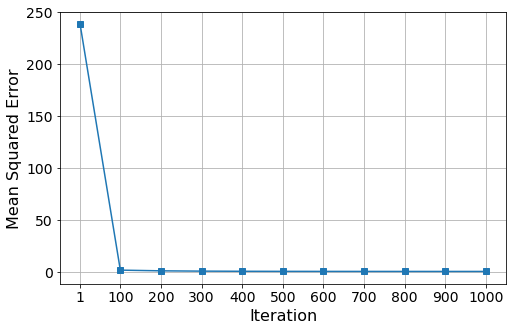

[0.11512224651003322, 0.11494443956261942, 0.11498971384392101, 0.11497602619428682, 0.11492431007324815, 0.11503273871045772, 0.11479439844743854, 0.11474605737457998, 0.11474186052137142, 0.11470345895775731]

{'batch_1': 35, 'batch_2': 14, 'batch_3': 21, 'batch_4': 46, 'batch_5': 9, 'batch_6': 20, 'batch_7': 47, 'batch_8': 42, 'batch_9': 41, 'batch_10': 32, 'batch_11': 17, 'batch_12': 16, 'batch_13': 34, 'batch_14': 24, 'batch_15': 1, 'batch_16': 22, 'batch_17': 12, 'batch_18': 28, 'batch_19': 39, 'batch_20': 2, 'batch_21': 50, 'batch_22': 23, 'batch_23': 26, 'batch_24': 11, 'batch_25': 43, 'batch_26': 8, 'batch_27': 10, 'batch_28': 18, 'batch_29': 13, 'batch_30': 19, 'batch_31': 15, 'batch_32': 33, 'batch_33': 44, 'batch_34': 49, 'batch_35': 5, 'batch_36': 29, 'batch_37': 30, 'batch_38': 7, 'batch_39': 40, 'batch_40': 48, 'batch_41': 45, 'batch_42': 37, 'batch_43': 25, 'batch_44': 38, 'batch_45': 27, 'batch_46': 4, 'batch_47': 3, 'batch_48': 36, 'batch_49': 6, 'batch_50': 31}


In [10]:
plot_IP_loss_evolution(return_dict,
                       start_iteration = 1,
                       reg_line = True,
                       tick_diff = 100,
                       marker = True,
                       at_tick = True,
                       xlabel = "Iteration",
                       save = None)#"../img/inverse_problem/loss_mse_P50_B20_BPC_Reg_Var.png")
print(return_dict["loss_evolution"][-10:])
print("")
print(return_dict["batch_particle_dict"])

In [299]:
print("EnKF:", np.linalg.norm(return_dict["final_params"]))
if return_dict["x_opt_subspace"] is not None:
    print("Subspace:", np.linalg.norm(return_dict["x_opt_subspace"]))
if return_dict["x_opt_fullSpace"] is not None:
    print("Full Space:", np.linalg.norm(return_dict["x_opt_fullSpace"]))

EnKF: 5.4842287411014405
Full Space: 5.615613426029924


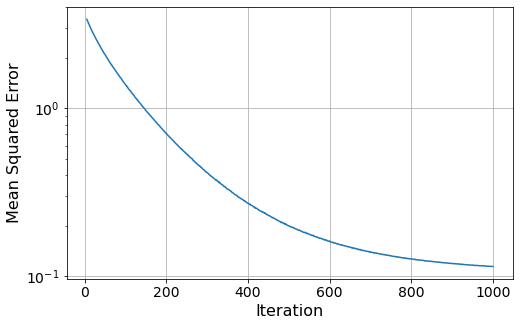

In [342]:
plot_IP_convergence(return_dict,
                    log = "semi_log",
                    xlabel = "Iteration",
                    save = "../img/inverse_problem/loss_conv_P50_B20_BPC_Reg_Var_semilog.png")

In [78]:
from sklearn.metrics.pairwise import cosine_similarity

0.9708563879967425

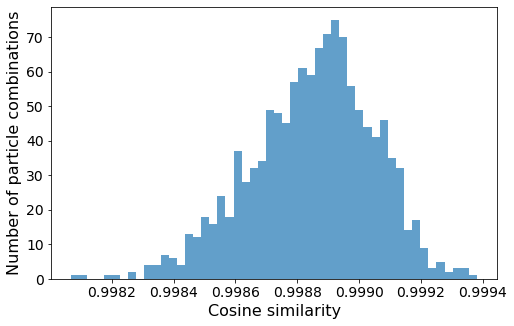

In [344]:
plot_IP_final_cosine_sim(return_dict,
                         bins = 50,
                         opt_comparison = False,
                         save = "../img/inverse_problem/cosine_P50_B20_BPC_Reg_Var.png")

In [122]:
A = np.random.uniform(size = (1000, 200), low = 0, high = 1)
x = np.random.uniform(size = (A.shape[1], ))

def model_func(x):
    return np.dot(A, x)

noise = False

y, std = y_noise(model_func,
                 x, 
                 noise)

setting_dict = {"A": A,
                "model_func": model_func,
                "x": x,
                "y": y,
                "particles": 50,
                "epochs": 20,
                "batch_size" : 200,     # A.shape[0]           
                "noise": noise,
                "std": std,
                "h_0": 2,
                "epsilon": 3,
                "randomization": False,
                "loss": "mse"
                }
analysis_dict = {"disjoint_batch": True,
                 "batch_particle_connection": {"connect": True,
                                               "shuffle": "full"},       # None, "full", "batch", "particle", "permute"
                 "tikhonov": {"regularize": False,
                              "lambda": 15}
                }

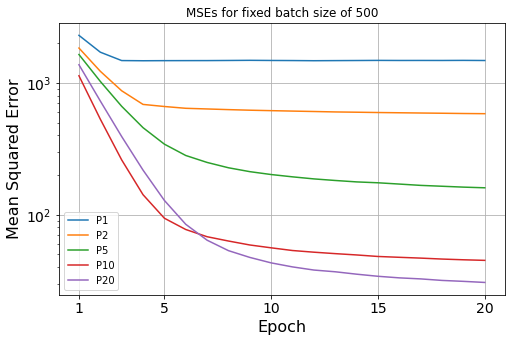

In [24]:
# Für den Approximationsfehler
# Beachte: Unterschiedlich große initiale Ensembles und demnach unterschiedlich zeitaufwändig

# Mit logarithmischer Skalierung

import matplotlib.pyplot as plt

if not analysis_dict["batch_particle_connection"]["connect"]:
    raise ValueError("Batch-particle connection must be true.")

batch_size = 500
particles_per_batch = [1, 2, 5, 10, 20]

start_epoch = 1
xlabel = "Epoch"
save = None

loss_evolution_dict = {}

for p in particles_per_batch:
    np.random.seed(42)
    setting_dict["batch_size"] = batch_size
    particles = int(setting_dict["A"].shape[0] / batch_size * p)
    setting_dict["particles"] = particles
    
    return_dict = enkf_linear_inverse_problem_analysis(setting_dict,
                                                       analysis_dict)
    loss_evolution_dict["P{}".format(p)] = return_dict["loss_evolution"]
    
xticks = np.linspace(start = 0,
                     stop = len(loss_evolution) - 1,
                     num = int((len(loss_evolution) - 1) / 5 + 1))
xticks = np.delete(xticks, np.where(xticks <= start_epoch))
xticks = np.append(xticks, [start_epoch])
    
plt.figure(figsize = (8,5))
for p in particles_per_batch:
    plt.plot(np.arange(len(loss_evolution_dict["P{}".format(p)]))[start_epoch:], 
             loss_evolution_dict["P{}".format(p)][start_epoch:],
             label = "P{}".format(p))
plt.legend()
plt.grid()
plt.xlabel(xlabel, fontsize = 16)
plt.ylabel("Mean Squared Error", fontsize = 16)
plt.xticks(ticks = xticks, fontsize = 14)
plt.yticks(fontsize = 14)
plt.yscale("log")
if save is not None:
    plt.savefig(save)
plt.title("MSEs for fixed batch size of {}".format(batch_size))
plt.show()

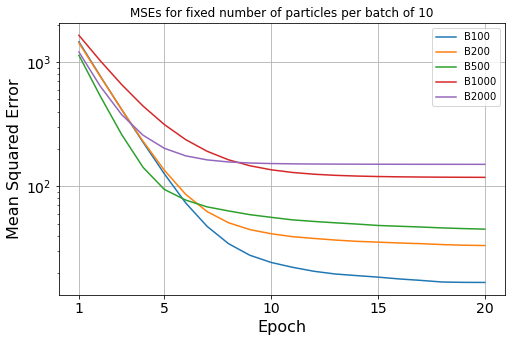

In [25]:
# Für den Approximationsfehler
# Beachte: Unterschiedlich große initiale Ensembles und demnach unterschiedlich zeitaufwändig

# Mit logarithmischer Skalierung

import matplotlib.pyplot as plt

if not analysis_dict["batch_particle_connection"]["connect"]:
    raise ValueError("Batch-particle connection must be true.")

batch_sizes = [100, 200, 500, 1000, 2000] 
particles_per_batch = 10

start_epoch = 1
xlabel = "Epoch"
save = None

loss_evolution_dict = {}

for b in batch_sizes:
    np.random.seed(42)
    setting_dict["batch_size"] = b
    particles = int(setting_dict["A"].shape[0] / b * particles_per_batch)
    setting_dict["particles"] = particles
    
    return_dict = enkf_linear_inverse_problem_analysis(setting_dict,
                                                       analysis_dict)
    loss_evolution_dict["B{}".format(b)] = return_dict["loss_evolution"]
    
xticks = np.linspace(start = 0,
                     stop = len(loss_evolution) - 1,
                     num = int((len(loss_evolution) - 1) / 5 + 1))
xticks = np.delete(xticks, np.where(xticks <= start_epoch))
xticks = np.append(xticks, [start_epoch])
    
plt.figure(figsize = (8,5))
for b in batch_sizes:
    plt.plot(np.arange(len(loss_evolution_dict["B{}".format(b)]))[start_epoch:], 
             loss_evolution_dict["B{}".format(b)][start_epoch:],
             label = "B{}".format(b))
plt.legend()
plt.grid()
plt.xlabel(xlabel, fontsize = 16)
plt.ylabel("Mean Squared Error", fontsize = 16)
plt.xticks(ticks = xticks, fontsize = 14)
plt.yticks(fontsize = 14)
plt.yscale("log")
if save is not None:
    plt.savefig(save)
plt.title("MSEs for fixed number of particles per batch of {}".format(particles_per_batch))
plt.show()

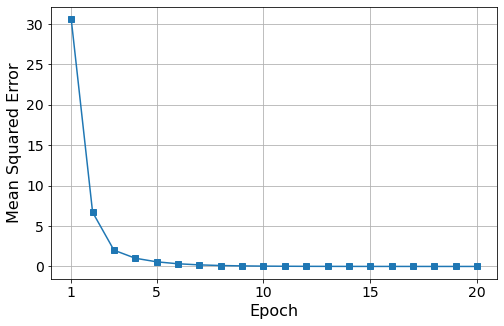

[0.025918261866953826,
 0.016376567053304432,
 0.010695341990468224,
 0.007270366228958053,
 0.005162693012660197,
 0.003827541792136832,
 0.002951594026890599,
 0.0023549900137744247,
 0.0019335089292038738,
 0.0016255355106583672]

In [51]:
setting_dict = {"model_func": model_func,
                "x": x,
                "y": y,
                "particles": 200,
                "iterations": 20,
                "noise": noise,
                "std": std,
                "h_0": 2,
                "epsilon": 0.5,
                "randomization": False
                }
final_params, loss_evolution, loss_evolution_single_dict = enkf_inverse_problem(setting_dict)
plot_IP_loss_evolution(loss_evolution,
                       start_iteration = 1,
                       xlabel = "Epoch",
                       save = None)
loss_evolution[-10:]

c:\users\morit\anaconda3\envs\master_thesis\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


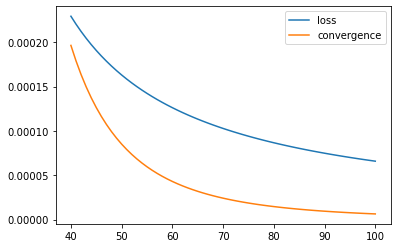

In [59]:
import matplotlib.pyplot as plt

conv = setting_dict["particles"] / np.arange(setting_dict["iterations"]+1)**3.75

plt.plot(np.arange(len(loss_evolution))[40:], loss_evolution[40:], label = "loss")
plt.plot(np.arange(len(loss_evolution))[40:], conv[40:], label = "convergence")
plt.legend()
plt.show()